In [1]:
# Generic Comment
#* Important Comment
#! Warning
#? Suggestion
#TODO Todo list

import time
start_time = time.time()
import cyipopt
import math
import matplotlib.pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
from numba import *
%matplotlib widget

def compute_index(indices, dims):
    if len(indices) == 1:
        return indices[0]
    else:
        current_index = indices[0]
        remaining_dims_product = 1
        for dim in dims[1:]:
            remaining_dims_product *= dim
        return current_index * remaining_dims_product + compute_index(indices[1:], dims[1:])
        
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 5.534947 seconds 


In [2]:
start_time = time.time()

public_key, private_key = paillier.generate_paillier_keypair(n_length=256)
d1=12
def encrypt(val):
    return public_key.encrypt(val,precision = 2**(-d1))
def decrypt(val):
    return private_key.decrypt(val)

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Encryption dependencies = %f seconds " % total_runtime)

Total time required to initialize Encryption dependencies = 0.006369 seconds 


In [3]:
start_time = time.time()
######### Simulation time #########################

hc = 1e-4  # hr Numerical Integration Step Size
tFinal = 5  # hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps = int( tFinal / hc)  # Number of calculated steps


controlStepSize   = 10 # Integration Steps per MPC Control Step
setpointStepSize  = 2 # Integration Steps per Set-Point        
PIcontrolStepSize = 1   # Integration Steps per PI Control Step

NUM_MPC_ITERATION = int(netTimeSteps/controlStepSize)  # Number of times simulation is run
HORIZON_LENGTH = 7

netControlTimeSteps   = int( netTimeSteps / controlStepSize   )
netSetPointTimeSteps  = int( netTimeSteps / setpointStepSize  )
netPIControlTimeSteps = int( netTimeSteps / PIcontrolStepSize )

controlTimeStepsPerMPC   = int( HORIZON_LENGTH * netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerMPC  = int( HORIZON_LENGTH * netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerMPC = int( HORIZON_LENGTH * netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerMPC          = int( HORIZON_LENGTH * netTimeSteps          / NUM_MPC_ITERATION )

controlTimeStepsPerControlAction   = int( netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerControlAction  = int( netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerControlAction = int( netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerControlAction          = int( netTimeSteps          / NUM_MPC_ITERATION )

NUM_OUTPUTS = 2  # Model Outputs: x1 x2
NUM_INPUTS = 4  # Model  Inputs: u1 u2 x1 x2
NUM_U = int(NUM_INPUTS - NUM_OUTPUTS)  # Number of control inputs


NUM_MPC_INPUTS = int(NUM_U * controlTimeStepsPerMPC)  # 1 set of control inputs per Horizon
NUM_MPC_CONSTRAINTS = controlTimeStepsPerMPC  # Constraints must be satisfied at all points

delta = controlStepSize * hc  # Step size for the system model
################### P matrix #############################
# V= xTP(x) "Energy of Sys"

a = 1060
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
# Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
# Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
loopsPerHour = int((1.0/hc)/controlStepSize)
A1 = np.repeat(np.array([1, 0.99, 1.01, 0.98, 1.02]),loopsPerHour)
A2 = np.repeat(np.array([17, 14, 5, 7, 9]),loopsPerHour)
A3 = np.repeat(np.array([1e-8, 0.8 * 1e-8, 0.84 * 1e-8, 0.9 * 1e-8, 0.92e-8]),loopsPerHour)

end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Control Paramters = %f seconds " % total_runtime
)

Total time required to initialize Control Paramters = 0.000000 seconds 


In [4]:
start_time = time.time()
##################### initial values and initializations ######################

# Initial Values in Deviation Variable Form
CA = 0  # kmol/m3
x[1] = 0  # K

setpoint_record  = np.zeros((NUM_OUTPUTS, netSetPointTimeSteps))
V_record         = np.zeros(netTimeSteps)
x_record         = np.zeros((NUM_OUTPUTS, netTimeSteps + 1))
x_real           = np.array([[CA], [x[1]]])
x_record[:, [0]] = x_real


u_record        = np.zeros((NUM_U, netPIControlTimeSteps))
uMPC_record     = np.zeros((NUM_U, netControlTimeSteps))
#grad_f_record = []

encrypted_e1 = []
encrypted_e2 = []

message_record    = []

status_record     = np.zeros(NUM_MPC_ITERATION)
cost_record       = np.zeros(NUM_MPC_ITERATION)
constraint_record = np.zeros((controlTimeStepsPerMPC,NUM_MPC_ITERATION))

realtime_data = None
cost = 0.0

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

NameError: name 'x' is not defined

In [ ]:
start_time = time.time()
@njit
def model_makestep(x[0], x[1], CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (x[1] + Ts)) * (x[0] + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - x[0])
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - x[1])
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        x[0] += hc * fun_1
        x[1]  += hc * fun_2
    return CA, x[1]
def solvePI(CA,x[1],CA_setpoint,T_setpoint):
    encrypted_CA_setpoint = encrypt(CA_setpoint)
    encrypted_T_setpoint  = encrypt(T_setpoint)
    encrypted_CA          = encrypt(CA)
    encrypted_T           = encrypt(x[1])
    encrypted_error1      = encrypted_CA_setpoint-encrypted_CA
    encrypted_error2      = encrypted_T_setpoint-encrypted_T
    encrypted_e1.append(encrypted_error1)
    encrypted_e2.append(encrypted_error2)

    Kc1    = 10
    Kc2    = 10000
    K_I1 = 20
    K_I2 = 20
    encrypted_CA0 = Kc1*encrypted_error1+K_I1*(PIcontrolStepSize*hc*sum(encrypted_e1))
    encrypted_Q   = Kc2*encrypted_error2+K_I2*(PIcontrolStepSize*hc*sum(encrypted_e2))
    CA0           = decrypt(encrypted_CA0)
    Q             = decrypt(encrypted_Q)
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
def solvePI2(CA,x[1],CA_setpoint,T_setpoint):
    encrypted_CA_setpoint = encrypt(CA_setpoint)
    encrypted_T_setpoint  = encrypt(T_setpoint)
    encrypted_CA          = encrypt(CA)
    encrypted_T           = encrypt(x[1])
    encrypted_error1      = encrypted_CA_setpoint-encrypted_CA
    encrypted_error2      = encrypted_T_setpoint-encrypted_T
    encrypted_e1.append(encrypted_error1)
    encrypted_e2.append(encrypted_error2)

    Kc1    = 1000
    Kc2    = 1000000
    K_I1 = 2
    K_I2 = 2
    encrypted_CA0 = Kc1*encrypted_error1+K_I1*(PIcontrolStepSize*hc*sum(encrypted_e1))
    encrypted_Q   = Kc2*encrypted_error2+K_I2*(PIcontrolStepSize*hc*sum(encrypted_e2))
    CA0           = decrypt(encrypted_CA0)
    Q             = decrypt(encrypted_Q)
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
CAO_L = -3.5
CAO_U = 3.5
Q_L = -5e5
Q_U = 5e5
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize MPC Constraints = %f seconds " % total_runtime)

SyntaxError: invalid syntax (1456524679.py, line 3)

In [48]:
from casadi import *
################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

CA = MX.sym('CA')
T = MX.sym('T')
x = vertcat(CA, T)
print(x)
CA0 = MX.sym('CA0')
Q = MX.sym('Q')
u = vertcat(CA0, Q)

exp_E_over_R_Ts__CAs = exp(E_over_R / (Ts)) * (CAs) ** 2
exp_E_over_R_T__CA   = exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
dCA = (
    Coeff1 * (CA0 - CA)
    - k0 * exp_E_over_R_T__CA 
    + k0 * exp_E_over_R_Ts__CAs 
)
dT = (
    Coeff1 * (T0 - T0s - T)
    - Coeff2 * exp_E_over_R_T__CA
    + Coeff2 * exp_E_over_R_Ts__CAs
    + (Q) / Coeff3
)
stepsize = MX.sym('hc')
ode = vertcat(stepsize*dCA, stepsize*dT)

N = 20
hc = 1e-4

f = Function('f', [x,u,stepsize], [ode],['CA,T','CA0,Q','hc'],['dCA,dT'])
dae = {'x': x, 'p': vertcat(u,stepsize), 'ode': f(x,u,stepsize)}
opts1 = {'expand':True,
         'show_eval_warnings': False,
         #"regularity_check": True,  # This enables checking for inf/nan
         #'number_of_finite_elements': 100000,
    } # 'simplify':True
F = integrator('F', 'rk', dae,opts1)
t=MX.sym('t')
tf = 10000e-4
quad = 0.
ode = vertcat(dCA, dT)
dae = {'t':t, 'x':x, 'p':u, 'ode':ode, 'quad':quad}
I = integrator('I', 'rk', dae, 0, tf, opts1)
makeStep = integrator('makeStep', 'rk', dae, 0, hc, opts1)
#F.print_options()
# print(f([0.0, 0.0], [0, 1],1e-4))
# print(F)
result = F(x0=[0.0, 0.0], p=vertcat([0, 1],10000e-4))
print(result['xf'])
result = I(x0=[0.0, 0.0], p=[0, 1])
print(result['xf'])
x0=[0.0, 0.0]
p=[0, 1]
steps = int(1/hc)
for i in range(steps):
    x0 = makeStep(x0=x0, p=p)['xf']
print(x0)
hc = 1e-4
def model_makestep(x, CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (x[1] + Ts)) * (x[0] + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - x[0])
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - x[1])
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        x[0] += hc * fun_1
        x[1]  += hc * fun_2
    return x[0], x[1]
print(model_makestep([0.0, 0.0], 0, 1,steps = int(1/hc)))


vertcat(CA, T)
[-0.00173315, 0.0871425]
[-0.00173315, 0.0871425]
[-0.0017332, 0.0871446]
(np.float64(-0.0017320823744106676), np.float64(0.08708918355115328))


In [ ]:
print(model_makestep([1.5683420540402588, -2.3727938117875165 ], -361146.06268138683 , 344751.99987453234,steps = 1))

print(CAs)
print(Ts)



(np.float64(-179.00749250659842), np.float64(-2.121848702556166))
1.9537
401.87


In [53]:
import random
import numpy as np
from casadi import *

# Assuming 'F' is already defined as an integrator function from CasADi
while True:
    x1 = random.uniform(-1.9537, 1.9537)
    x2 = random.uniform(-400, 400)
    u1 = random.uniform(-3.5, 3.5)
    u2 = random.uniform(-5e5, 5e5)
    #print(f"Testing solver F with inputs x1={x1}, x2={x2}, u1={u1}, u2={u2}")
    try:
        result = F(x0=[x1, x2], p=vertcat([u1, u2], hc))
        
        # Convert CasADi DM to NumPy array for checking
        result_np = result['xf'].full().flatten()
        
        # Check for inf or nan in the result
        if np.any(np.isinf(result_np)) or np.any(np.isnan(result_np)):
            print(f"Found inf or nan in the result of solver F: {result_np}")
            break
    except Exception as e:
        # Handle any exceptions from the solver
        print(f"An error occurred: {e}")
        break
    try:
        result = makeStep(x0=[x1, x2], p=[u1, u2])
        
        # Convert CasADi DM to NumPy array for checking
        result_np = result['xf'].full().flatten()
        
        # Check for inf or nan in the result
        if np.any(np.isinf(result_np)) or np.any(np.isnan(result_np)):
            print(f"Found inf or nan in the result of solver makeStep: {result_np}")
            break
    except Exception as e:
        # Handle any exceptions from the solver
        print(f"An error occurred: {e}")
        break

# Print the result and the inputs that caused the inf/nan
print(result['xf'])
print(result['xf'].full().flatten())
print(x1, x2, u1, u2)


KeyboardInterrupt: 

In [ ]:
An error occurred: <built-in function Function_call> returned a result with an exception set
[0.942621, 53.0347]
[ 0.9426211  53.03470605]
0.5996083090355153 344.18647241092003 -1.46650368599047 -304531.05683389667

In [49]:
import timeit
import random

import timeit
import random
import numpy as np

def timeFunction(function, *params, runs=100, per_run=100, **kwargs):
    def random_stmt():
        # Generate new random inputs for each execution
        if function == model_makestep:
            return function([random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1), random.uniform(-1, 1), steps=int(1/hc))
        else:
            return function(x0=[random.uniform(-1, 1), random.uniform(-1, 1)], p=[random.uniform(-1, 1), random.uniform(-1, 1)])

    # Use timeit.repeat to get multiple measurements
    timings = timeit.repeat(stmt=random_stmt, repeat=runs, number=per_run)

    # Convert timings into numpy array for easier statistical analysis
    timings = np.array(timings) / per_run  # Convert to time per execution

    # Calculate statistics
    mean = np.mean(timings)
    std_dev = np.std(timings)
    max_time = np.max(timings)
    min_time = np.min(timings)
    percentile_1 = np.percentile(timings, 1)   # 1% Low
    percentile_5 = np.percentile(timings, 5)   # 5% Low
    percentile_95 = np.percentile(timings, 95)  # 5% High
    percentile_99 = np.percentile(timings, 99)  # 1% High

    # Print statistics
    print(f"Function: {function}")
    print(f"Mean execution time: {mean:.9f} seconds")
    print(f"Standard Deviation: {std_dev:.9f}")
    #print(f"1% Low: {percentile_1:.9f} seconds")
    #print(f"5% Low: {percentile_5:.9f} seconds")
    #print(f"1% High: {percentile_99:.9f} seconds")
    #print(f"5% High: {percentile_95:.9f} seconds")
    #print(f"Min execution time: {min_time:.9f} seconds")
    #print(f"Max execution time: {max_time:.9f} seconds")

# Assuming 'model_makestep' and 'F' are defined, 'hc' is set somewhere in your code
timeFunction(model_makestep,runs=10,per_run=10) #.0347
timeFunction(makeStep,runs=10,per_run=10000)


Function: <function model_makestep at 0x000001709EF74720>
Mean execution time: 0.031950464 seconds
Standard Deviation: 0.001884489
Function: makeStep:(x0[2],z0[0],p[2],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[2],zf[0],qf,adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta
Mean execution time: 0.000070668 seconds
Standard Deviation: 0.000003270


In [ ]:
from numba import njit
import numpy as np
@njit
def model_makestep(CA, x[1], CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - CA)
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - T)
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        CA += hc * fun_1
        T  += hc * fun_2
    return CA, T

In [ ]:
################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3




HORIZON = 5
from casadi import *
CA = MX.sym('CA')
T = MX.sym('T')
X = vertcat(CA,T)
CA0 = MX.sym('CA0')
Q = MX.sym('Q')
U = vertcat(CA0,Q)
hc = MX.sym('hc')
def modelMakeStep(x,u,hc):
    exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
    exp_E_over_R_T__CA   = np.exp(E_over_R / (x[1] + Ts)) * (x[0] + CAs) ** 2
    fun_1 = (
        Coeff1 * (u[0] - x[0])
        - k0 * exp_E_over_R_T__CA 
        + k0 * exp_E_over_R_Ts__CAs 
    )
    fun_2 = (
        Coeff1 * (T0 - T0s - x[1])
        - Coeff2 * exp_E_over_R_T__CA
        + Coeff2 * exp_E_over_R_Ts__CAs
        + (u[1]) / Coeff3
    )
    return vertcat(x[0]+hc*fun_1, x[1]+hc*fun_2)
def solveNextState(x,u,steps,hc):
    for i in range(steps):
        x = modelMakeStep(x,u,hc)
    return x
f = Function('f',[X,U,hc],[modelMakeStep(X,U,hc)],['x','u','hc'],['x_next'])

print(solveNextState([0,0],[0,1e10],5,1e-4))
opti = Opti()
E_over_R = opti.parameter()
Ts = opti.parameter()
T0 = opti.parameter()
T0s = opti.parameter()
CAs = opti.parameter()
Coeff1 = opti.parameter()
Coeff2 = opti.parameter()
Coeff3 = opti.parameter()
k0 = opti.parameter()
steps = opti.parameter()
hc = opti.parameter()
X0 = opti.parameter(2,1)
X = opti.variable(2,HORIZON+1)
U = opti.variable(2,HORIZON)

g = f.fold(5)
print(f)
print(g)
print(g(vertcat(0.0,0.0),[0.0,1e10],1e-4))


[-8.85506e+43, 4.40836e+45]
f:(x[2],u[2],hc)->(x_next[2]) MXFunction
fold_f:(x[2],u[2x5],hc[1x5])->(x_next[2]) MXFunction
[-8.85506e+43, 4.40836e+45]


In [ ]:
sin(3.3)*1.1

-0.17352026355757305

In [ ]:
y = MX(4)
print(y+1)

5


In [ ]:
import casadi as ca

# Define state and time
x = ca.SX.sym('x', 2)
t = ca.SX.sym('t')

# Define the ODE
ode = ca.vertcat(x[1], -x[0])

# Define the right-hand side of the ODE
f = ca.Function('f', [x, t], [ode])

# Define the integrator
# Here we use the 'rk' method which includes Euler as a special case with order 1
integrator = ca.integrator('F', 'rk', {'x': x, 'p': t, 'ode': f(x, t)})

# To use the integrator for a single step:
# x0 = ca.DM([1.0, 0.0])  # Initial state
# t0 = 0.0  # Initial time
# dt = 0.1  # Time step
# result = integrator(x0=x0, p=t0, t0=t0, tf=t0+dt)

# To run for multiple steps, you'd do something like this:
def simulate_multiple_steps(integrator, x0, t0, dt, N):
    X = [x0]
    t = t0
    for _ in range(N):
        result = integrator(x0=X[-1], p=t, t0=t, tf=t+dt)
        X.append(result['xf'])
        t += dt
    return ca.horzcat(*X)

# Usage would be:
x0 = ca.DM([1.0, 0.0])
N = 100  # Number of steps
dt = 0.1
X = simulate_multiple_steps(integrator, x0, 0.0, dt, N)

RuntimeError: Error in Function::call for 'F' [RungeKutta] at .../casadi/core/function.cpp:1432:
.../casadi/core/function_internal.hpp:1091: FunctionInternal::index_in: could not find entry "t0". Available names are: [x0, z0, p, u, adj_xf, adj_zf, adj_qf].

In [ ]:
#
#     MIT No Attribution
#
#     Copyright (C) 2010-2023 Joel Andersson, Joris Gillis, Moritz Diehl, KU Leuven.
#
#     Permission is hereby granted, free of charge, to any person obtaining a copy of this
#     software and associated documentation files (the "Software"), to deal in the Software
#     without restriction, including without limitation the rights to use, copy, modify,
#     merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
#     INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
#     PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
#     HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
#     SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#
# -*- coding: utf-8 -*-

from __future__ import print_function
from casadi import *
from copy import deepcopy
print('Testing sensitivity analysis in CasADi')

# All ODE and DAE integrators to be tested
DAE_integrators = ['idas','collocation']
ODE_integrators = ['cvodes','rk'] + DAE_integrators

for Integrators in (ODE_integrators,DAE_integrators):
  if Integrators==ODE_integrators: # rocket example
    print('******')
    print('Testing ODE example')

    # Time
    t = SX.sym('t')

    # Parameter
    u = SX.sym('u')

    # Differential states
    s = SX.sym('s'); v = SX.sym('v'); m = SX.sym('m')
    x = vertcat(s,v,m)

    # Constants
    alpha = 0.05 # friction
    beta = 0.1   # fuel consumption rate

    # Differential equation
    ode = vertcat(
      v,
      (u-alpha*v*v)/m,
      -beta*u*u)

    # Quadrature
    #quad = v**3 + ((3-sin(t)) - u)**2
    quad = v**3
    # DAE callback function
    dae = {'t':t, 'x':x, 'p':u, 'ode':ode, 'quad':quad}

    # Time length
    tf = 0.5

    # Initial position
    x0 = [0.,0.,1.]

    # Parameter
    u0 = 0.4

  else: # Simple DAE example
    print('******')
    print('Testing DAE example')

    # Differential state
    x = SX.sym('x')

    # Algebraic variable
    z = SX.sym('z')

    # Parameter
    u = SX.sym('u')

    # Differential equation
    ode = -x + 0.5*x*x + u + 0.5*z

    # Algebraic constraint
    alg = z + exp(z) - 1.0 + x

    # Quadrature
    quad =x*x +  3.0*u*u

    # DAE callback function
    dae = {'x':x, 'z':z, 'p':u, 'ode':ode, 'alg':alg, 'quad':quad}

    # End time
    tf = 5.

    # Initial position
    x0 = 1.

    # Parameter
    u0 = 0.4

  # Integrator
  for MyIntegrator in Integrators:
    print('========')
    print('Integrator: ', MyIntegrator)
    print('========')

    # Integrator options
    opts = {}
    if MyIntegrator=='collocation':
      opts['rootfinder'] = 'kinsol'

    # Integrator
    
    I = integrator('I', MyIntegrator, dae, 0, tf, opts)

    # Integrate to get results
    res = I(x0=x0, p=u0)
    xf = res['xf'].full()
    qf = res['qf'].full()
    print('%50s' % 'Unperturbed solution:', 'xf  = ', xf, ', qf  = ', qf)

    # Perturb solution to get a finite difference approximation
    h = 0.001
    res = I(x0=x0, p=u0+h)
    fd_xf = (res['xf']-xf)/h
    fd_qf = (res['qf']-qf)/h
    print('%50s' % 'Finite difference approximation:', 'd(xf)/d(p) = ', fd_xf, ', d(qf)/d(p) = ', fd_qf)

    # Calculate once, forward
    I_fwd = I.factory('I_fwd', ['x0', 'z0', 'p', 'fwd:p'], ['fwd:xf', 'fwd:qf'])
    res = I_fwd(x0=x0, p=u0, fwd_p=1)
    fwd_xf = res['fwd_xf']
    fwd_qf = res['fwd_qf']
    print('%50s' % 'Forward sensitivities:', 'd(xf)/d(p) = ', fwd_xf, ', d(qf)/d(p) = ', fwd_qf)

    # Calculate once, adjoint
    I_adj = I.factory('I_adj', ['x0', 'z0', 'p', 'adj:qf'], ['adj:x0', 'adj:p'])
    res = I_adj(x0=x0, p=u0, adj_qf=1)
    adj_x0 = res['adj_x0']
    adj_p = res['adj_p']
    print('%50s' % 'Adjoint sensitivities:', 'd(qf)/d(x0) = ', adj_x0, ', d(qf)/d(p) = ', adj_p)

    # Perturb adjoint solution to get a finite difference approximation of the second order sensitivities
    res = I_adj(x0=x0, p=u0+h, adj_qf=1)
    fd_adj_x0 = (res['adj_x0']-adj_x0)/h
    fd_adj_p = (res['adj_p']-adj_p)/h
    print('%50s' % 'FD of adjoint sensitivities:', 'd2(qf)/d(x0)d(p) = ', fd_adj_x0, ', d2(qf)/d(p)d(p) = ', fd_adj_p)

    # Forward over adjoint to get the second order sensitivities
    I_foa = I_adj.factory('I_foa', ['x0', 'z0', 'p', 'adj_qf', 'fwd:p'], ['fwd:adj_x0', 'fwd:adj_p'])
    res = I_foa(x0=x0, p=u0, adj_qf=1, fwd_p=1)
    fwd_adj_x0 = res['fwd_adj_x0']
    fwd_adj_p = res['fwd_adj_p']
    print('%50s' % 'Forward over adjoint sensitivities:', 'd2(qf)/d(x0)d(p) = ', fwd_adj_x0, ', d2(qf)/d(p)d(p) = ', fwd_adj_p)

    # Adjoint over adjoint to get the second order sensitivities
    I_aoa = I_adj.factory('I_aoa', ['x0', 'z0', 'p', 'adj_qf', 'adj:adj_p'], ['adj:x0', 'adj:p'])
    res = I_aoa(x0=x0, p=u0, adj_qf=1, adj_adj_p=1)
    adj_x0 = res['adj_x0']
    adj_p = res['adj_p']
    print('%50s' % 'Adjoint over adjoint sensitivities:', 'd2(qf)/d(x0)d(p) = ', adj_x0, ', d2(qf)/d(p)d(p) = ', adj_p)

Testing sensitivity analysis in CasADi
******
Testing ODE example
Integrator:  cvodes
                             Unperturbed solution: xf  =  [[0.05009173]
 [0.20046757]
 [0.992     ]] , qf  =  [[0.00100935]]
                  Finite difference approximation: d(xf)/d(p) =  [0.125797, 0.504365, -0.04005] , d(qf)/d(p) =  0.00760665
                            Forward sensitivities: d(xf)/d(p) =  [0.125795, 0.504352, -0.04] , d(qf)/d(p) =  0.0075887
                            Adjoint sensitivities: d(qf)/d(x0) =  [0, 0.0200198, -0.00302191] , d(qf)/d(p) =  0.00758744
                      FD of adjoint sensitivities: d2(qf)/d(x0)d(p) =  [0, 0.100572, -0.0228925] , d2(qf)/d(p)d(p) =  0.0385618
               Forward over adjoint sensitivities: d2(qf)/d(x0)d(p) =  [0, 0.100447, -0.0228157] , d2(qf)/d(p)d(p) =  0.0384601
               Adjoint over adjoint sensitivities: d2(qf)/d(x0)d(p) =  [0, 0.100447, -0.0228157] , d2(qf)/d(p)d(p) =  0.0384601
Integrator:  rk
                          

In [ ]:
(0.200468**3 + ((3-sin(0.5)) - 0.4)**2)*0.5

2.252446168920489

In [ ]:
(v**3 * 0.5 + ((3-sin(t)) - u)**2)
v= (0.200468/2)**3 t**4 / 4

0.050117

In [1]:
################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

In [ ]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

def system_dynamics():
    # Define symbolic variables
    CA = MX.sym('CA')
    T = MX.sym('T')
    x = vertcat(CA, T)
    CA0 = MX.sym('CA0')
    Q = MX.sym('Q')
    u = vertcat(CA0, Q)
    # Define dynamics
    exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
    exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
    dCA = (
        Coeff1 * (CA0 - CA)
        - k0 * exp_E_over_R_T__CA 
        + k0 * exp_E_over_R_Ts__CAs 
    )
    dT = (
        Coeff1 * (T0 - T0s - T)
        - Coeff2 * exp_E_over_R_T__CA
        + Coeff2 * exp_E_over_R_Ts__CAs
        + (Q) / Coeff3
    )
    xDot = vertcat(dCA, dT)
    ode = Function('ode', [x, u], [xDot])
    
    return ode
t=MX.sym('t')
tf = 10000e-4
quad = 0.
ode = vertcat(dCA, dT)
dae = {'t':t, 'x':x, 'p':u, 'ode':ode, 'quad':quad}
I = integrator('I', 'rk', dae, 0, tf, opts1)

In [3]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3


CA = MX.sym('CA')
T = MX.sym('T')
x = vertcat(CA, T)
CA0 = MX.sym('CA0')
Q = MX.sym('Q')
u = vertcat(CA0, Q)
t= MX.sym('t')
def system_dynamics():
    # Define dynamics
    exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
    exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
    dCA = (
        Coeff1 * (CA0 - CA)
        - k0 * exp_E_over_R_T__CA 
        + k0 * exp_E_over_R_Ts__CAs 
    )
    dT = (
        Coeff1 * (T0 - T0s - T)
        - Coeff2 * exp_E_over_R_T__CA
        + Coeff2 * exp_E_over_R_Ts__CAs
        + (Q) / Coeff3
    )
    ode = vertcat(dCA, dT)
    return ode
def create_integrator(tf:float):
    quad = 0.
    ode = system_dynamics()
    opts1 = {'expand':True,
         'show_eval_warnings': False,
         "regularity_check": True,  # This enables checking for inf/nan
         #'number_of_finite_elements': 100000,
    }
    dae = {'t':t, 'x':x, 'p':u, 'ode':ode, 'quad':quad}
    I = integrator('I', 'rk', dae, 0, tf, opts1)
    return I
def optimization_problem(N:int,delta:int,hc:float)->Function:
    opti = Opti("nlp")
    X = opti.variable(2, N+1)
    U = opti.variable(2, N)
    x0 = opti.parameter(2,1)
    #Xs = opti.parameter(2,N+1)

    opti.subject_to(X[:,0]==x0)
    ode = system_dynamics()
    makeSteps = create_integrator(hc*delta)
    for k in range(N):
        opti.subject_to(X[:, k+1] == makeSteps(x0=X[:, k], p=U[:, k])['xf'])
    opti.subject_to(opti.bounded(-CA0s ,U[0,:],3.5))
    opti.subject_to(opti.bounded(-5e5 ,U[1,:],5e5))
    opti.subject_to(opti.bounded(-CAs ,X[0,:],np.inf))
    opti.subject_to(opti.bounded(-Ts ,X[1,:],np.inf))
    #opti.subject_to(X[:,:] >= 0)  # CA must be non-negative
    cost = 0
    for k in range(N):
        #Q=diag(MX([1,1]))
        #mtimes(x.T,Q,x)
        #cost += (X[0, k] )**2 + (X[1, k] - 1000)**2 + 1e-3 * (U[0, k])**2 + 1e-3 * U[1, k]**2
        cost +=  (X[1, k+1] - 1000)**2
    opti.minimize(cost*delta*hc)
    solver = 'ipopt'
    p_opts = {'expand': True, 'verbose': False,'print_time': 0}
    s_opts = {
        'linear_solver': 'mumps',
        'print_level': 0, 
        'warm_start_init_point': "yes",
        'error_on_fail': True,
        'max_iter': 1000,
        'tol': 1e-8
    }  
    opti.solver(solver, p_opts, s_opts)
    #opti.solver(solver, p_opts)
    
    func = opti.to_function('controller', [x0, U], [U[:,0]], ['x0', 'u_init'], ['u'] )
    #func = opti.to_function('controller', [x0, Xs, u], [u[:,0]], ['x0','Xs', 'u_init'], ['u'] )
    return func
N = 5
delta=10
hc = 1e-4
makeStep = create_integrator(tf=hc*delta)
controller = optimization_problem(N=N,delta=delta,hc=hc)
ode = system_dynamics()

controlActions = 500
x0 = np.array([0.,0.]).reshape(2,-1)
u_ref = np.zeros((2,N))
x_log = np.zeros((2,controlActions+1))
x_log[:,0]  = x0.reshape(-1)
u_log = np.zeros((2,controlActions))
for i in range(controlActions):
    print("iteration", i)
    u = controller(x0, u_ref) 
    u_log[:,[i]] = u
    x0 = makeStep(x0=x0, p=u)['xf']
    x_log[:,[i+1]] = x0

iteration 0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       52
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:       22
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0000000e+03 0.00e+00 6.07e-02  -1.0 0.00e+00    -  0.00e+

In [31]:
x0

DM([-0.685145, 56.0051])

In [11]:
x_log

array([[ 0.        ,  0.01693749,  0.03268787,  0.04715113,  0.06021737,
         0.07176557],
       [ 0.        ,  2.18492915,  4.41385419,  6.69182844,  9.02439957,
        11.41766518]])

In [12]:
u_log

array([[3.49999968e+00, 3.49999970e+00, 3.49999972e+00, 3.49999974e+00,
        3.49999976e+00],
       [5.00000000e+05, 4.99999999e+05, 4.99999999e+05, 4.99999999e+05,
        4.99999999e+05]])

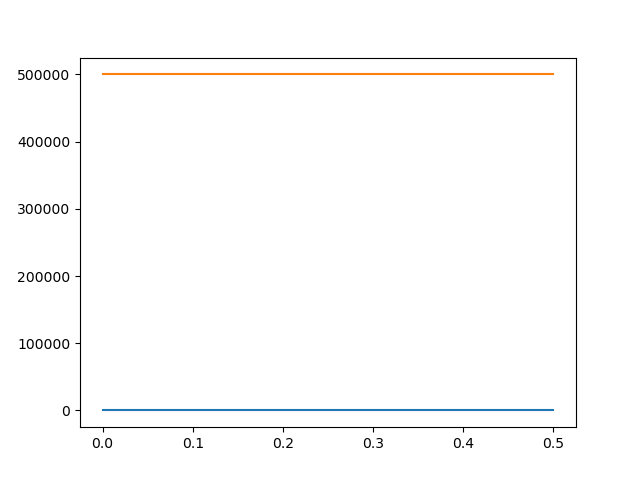

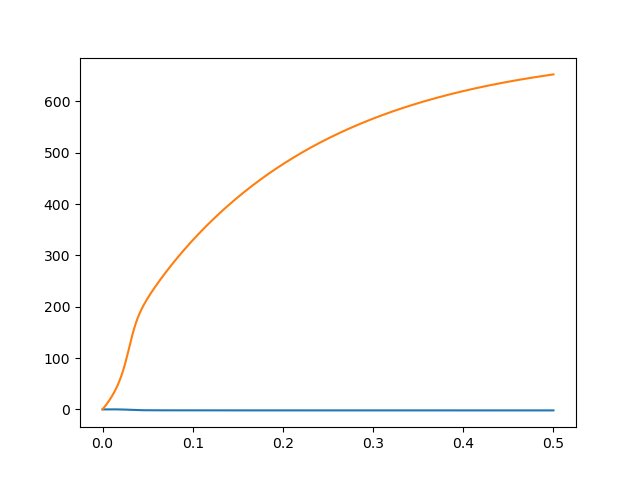

In [4]:
t=np.linspace(0,controlActions*delta*hc,controlActions+1)
%matplotlib widget
plt.close('all')
plt.figure("State")
plt.plot(t,x_log[0,:])
plt.plot(t,x_log[1,:])

plt.figure("input")
plt.step(t,np.append(u_log[0,:],u_log[0,-1]),where='post',label='CA0')
plt.step(t,np.append(u_log[1,:],u_log[1,-1]),where='post',label='Q')

plt.show()

In [25]:
test

array([ 3.49999968,  3.4999997 ,  3.49999972,  3.49999974,  3.49999976,
        3.49999978,  3.49999979,  3.49999981,  3.49999982,  3.49999983,
        3.49999984,  3.49999985,  3.49999985,  3.49999986,  3.49999986,
        3.49999987,  3.49999986,  3.49999986,  3.49999985,  3.49999983,
        3.49999979,  3.49999969,  3.49999983,  3.49999884,  3.49999626,
       -3.99993296, -3.99999174, -3.999993  , -3.99999631, -3.99999285,
       -3.99997994, -3.99969394, -0.61984801, -0.42599681, -0.54952595,
       -0.40547407, -0.31865706, -0.22582996, -0.19826714, -0.17489645,
       -0.23025916, -0.19408853, -0.16322947, -0.13613042, -0.09530631,
       -0.08449552, -0.07475512, -0.08758473, -0.0749979 , -0.06402041,
       -0.06402041])

In [6]:


import casadi as cs
import numpy as np
import matplotlib.pyplot as plt


def system_dynamics():
    x1 = cs.MX.sym("x1", 1,1)
    x2 = cs.MX.sym("x2", 1,1)
    x = cs.vertcat(x1,x2)

    u1 = cs.MX.sym("u1", 1,1)
    u2 = cs.MX.sym("u2", 1,1)
    u = cs.vertcat(u1,u2)

    x_next = cs.vertcat(-x1**3 - x2 + u1,
                        -2*x2 + u2)
    
    ode = cs.Function('ode',[x, u], [x_next], ['x','u'],['x_next'])
    return ode

def optimization_problem(N:int,delta:int)->cs.Function:
    opti = cs.Opti("nlp")
    x = opti.variable(2,N+1)
    u = opti.variable(2,N)
    x_ref = opti.parameter(2,N+1)
    x0 = opti.parameter(2,1)
    opti.subject_to(x[:,0]==x0)
    ode = system_dynamics()
    for k in range(N):
        X=x[:, k]
        for _ in range(delta):
            X += hc * ode(X, u[:, k])
        opti.subject_to(x[:, k+1] == X)
        #opti.subject_to(x[:, k+1] == ode(x[:,k], u[:, k]))
        opti.subject_to(opti.bounded(-100 ,u[:,k],100))
    
    cost = cs.sumsqr(x - x_ref) \
         + cs.sumsqr(u)
    
    opti.minimize(cost)
    solver = 'ipopt'
    p_opts = {'expand': True, 'verbose_init': False}
    s_opts = {'linear_solver': 'mumps','print_level': 0, 'warm_start_init_point': "yes",'error_on_fail': True}    
    opti.solver(solver, p_opts, s_opts)
    
    func = opti.to_function('controller', [x0, x_ref, u], [u[:,0]], ['x0','x_ref', 'u_init'], ['u'] )

    return func


N = 1
ode = system_dynamics()


controller = optimization_problem(N,10)

x0 = np.array([-3,2]).reshape(2,1)
x_ref = np.zeros((2,N+1))
u_ref = np.zeros((2,N))
x_log = np.zeros((2,10*N))
u_log = np.zeros((2,10*N))
for i in range(10*N):
    print("iteration", i)
    u = controller(x0, x_ref, u_ref) 
    u_log[:,i:i+1] = u 
    x_log[:,i:i+1] = x0
    x0 = ode(x0, u)

plt.figure("State")
plt.plot(x_log[0,:])
plt.plot(x_log[1,:])

plt.figure("input")
plt.plot(u_log[0,:])

plt.plot(u_log[1,:])
plt.show()

iteration 0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+

CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).")

 164r 2.0758791e+04 1.65e+01 5.12e+02  -7.9 3.56e+00    -  1.00e+00 1.00e+00h  1
 165r 2.0716853e+04 1.65e+01 6.33e+01  -7.9 1.44e+00    -  1.00e+00 1.00e+00h  1
 166r 2.0711257e+04 1.65e+01 1.46e+00  -7.9 2.03e-01    -  1.00e+00 1.00e+00h  1
 167r 2.0711145e+04 1.65e+01 8.51e-04  -7.9 4.11e-03    -  1.00e+00 1.00e+00h  1
 168r 2.0711145e+04 1.65e+01 7.72e-07  -7.9 1.93e-06    -  1.00e+00 1.00e+00h  1
 169r 2.0711145e+04 1.65e+01 2.68e-07  -7.9 4.98e-13    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 2.0711145e+04 1.65e+01 7.92e-03  -9.0 6.63e-07    -  1.00e+00 1.00e+00h  1
 171r 2.1023769e+04 1.65e+01 1.86e+02  -9.0 8.68e+00    -  1.00e+00 1.00e+00f  1
 172r 2.1195886e+04 1.65e+01 6.34e+00  -9.0 3.57e+00    -  1.00e+00 1.00e+00h  1
 173r 2.1192027e+04 1.65e+01 1.35e-02  -9.0 7.46e-02    -  1.00e+00 1.00e+00h  1
 174r 2.1192021e+04 1.65e+01 3.39e-07  -9.0 1.20e-04    -  1.00e+00 1.00e+00h  1
 175r 2.1192021e+04 1.65e+01

CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).")

 132r 1.6300009e+04 1.58e+04 1.23e+05  -2.1 8.60e-01    -  1.00e+00 1.00e+00h  1
 133r 1.6358548e+04 1.58e+04 1.07e+05  -2.1 8.35e-01    -  1.00e+00 1.00e+00h  1
 134r 1.6419170e+04 1.58e+04 9.59e+04  -2.1 8.44e-01    -  1.00e+00 1.00e+00h  1
 135r 1.6479709e+04 1.58e+04 8.22e+04  -2.1 8.24e-01    -  1.00e+00 1.00e+00h  1
 136r 1.6541378e+04 1.58e+04 7.03e+04  -2.1 8.21e-01    -  1.00e+00 1.00e+00h  1
 137r 1.6602780e+04 1.58e+04 5.78e+04  -2.1 8.00e-01    -  1.00e+00 1.00e+00h  1
 138r 1.6664056e+04 1.58e+04 4.62e+04  -2.1 7.82e-01    -  1.00e+00 1.00e+00h  1
 139r 1.6723977e+04 1.58e+04 3.49e+04  -2.1 7.50e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r 1.6781436e+04 1.58e+04 2.46e+04  -2.1 7.07e-01    -  1.00e+00 1.00e+00h  1
 141r 1.6834147e+04 1.58e+04 1.55e+04  -2.1 6.38e-01    -  1.00e+00 1.00e+00h  1
 142r 1.6878547e+04 1.58e+04 8.28e+03  -2.1 5.30e-01    -  1.00e+00 1.00e+00h  1
 143r 1.6909646e+04 1.58e+04

CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).")

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 3.8245222e+04 3.98e+12 4.37e+04   0.7 1.70e+02    -  1.00e+00 1.25e-01f  4
  71r 4.5035880e+04 3.98e+12 4.30e+05   0.7 1.50e+02    -  1.00e+00 1.25e-01f  4
  72r 5.3727041e+04 3.98e+12 4.44e+05   0.7 9.53e+01    -  1.00e+00 2.05e-01f  3
  73r 5.3830074e+04 3.98e+12 3.23e+04   0.7 2.74e-01   2.9 1.00e+00 1.00e+00f  1
  74r 5.3835370e+04 3.98e+12 2.80e+05   0.7 1.18e+00   3.3 4.20e-01 1.21e-01f  3
  75r 5.3835515e+04 3.98e+12 1.49e+05   0.7 2.96e-01   4.6 1.00e+00 4.52e-02h  3
  76r 5.3835515e+04 3.98e+12 1.49e+05   0.7 9.78e-02   5.9 0.00e+00 3.30e-07R 20
  77r 5.3835555e+04 3.98e+12 2.29e+04   0.7 4.80e-04   6.4 9.93e-01 1.00e+00f  1
  78r 5.3835666e+04 3.98e+12 6.66e+03   0.7 1.35e-03   5.9 1.00e+00 1.00e+00f  1
  79r 5.3835969e+04 3.98e+12 1.41e+03   0.7 4.32e-03   5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 5.3835878e+04 3.98e+12

CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 2, col 0).")

 234r 1.2852286e+05 3.98e+12 7.42e+09  -2.1 1.23e+01    -  1.00e+00 2.50e-01f  3
 235r 1.2855380e+05 3.98e+12 2.69e+09  -2.1 2.88e+00    -  1.00e+00 1.00e+00h  1
 236r 1.2855635e+05 3.98e+12 9.74e+08  -2.1 1.12e+00    -  1.00e+00 1.00e+00h  1
 237r 1.2856065e+05 3.98e+12 3.51e+08  -2.1 1.07e+00    -  1.00e+00 1.00e+00h  1
 238r 1.2856513e+05 3.98e+12 1.26e+08  -2.1 9.00e-01    -  1.00e+00 1.00e+00h  1
 239r 1.2856559e+05 3.98e+12 4.49e+07  -2.1 4.57e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 1.2855552e+05 3.98e+12 1.58e+07  -2.1 5.00e-01    -  1.00e+00 1.00e+00h  1
 241r 1.2853707e+05 3.98e+12 5.52e+06  -2.1 1.52e+00    -  1.00e+00 1.00e+00h  1
 242r 1.2852420e+05 3.98e+12 1.88e+06  -2.1 1.47e+00    -  1.00e+00 1.00e+00h  1
 243r 1.2851924e+05 3.98e+12 6.25e+05  -2.1 6.40e-01    -  1.00e+00 1.00e+00h  1
 244r 1.2851956e+05 3.98e+12 2.01e+05  -2.1 4.44e-01    -  1.00e+00 1.00e+00h  1
 245r 1.2852842e+05 3.98e+12

CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-02-07 17:20:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2, col 0).")

RuntimeError: Error in Function::call for 'controller' [MXFunction] at .../casadi/core/function.cpp:361:
Error in Function::operator() for 'solver' [IpoptInterface] at .../casadi/core/function.cpp:1513:
.../casadi/core/nlpsol.cpp:642: Assertion "lb <= ub && lb!=inf && ub!=-inf" failed:
Ill-posed problem detected: LBG[0] <= UBG[0] was violated. Got LBG[0] = -inf and UBG[0] = -inf.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

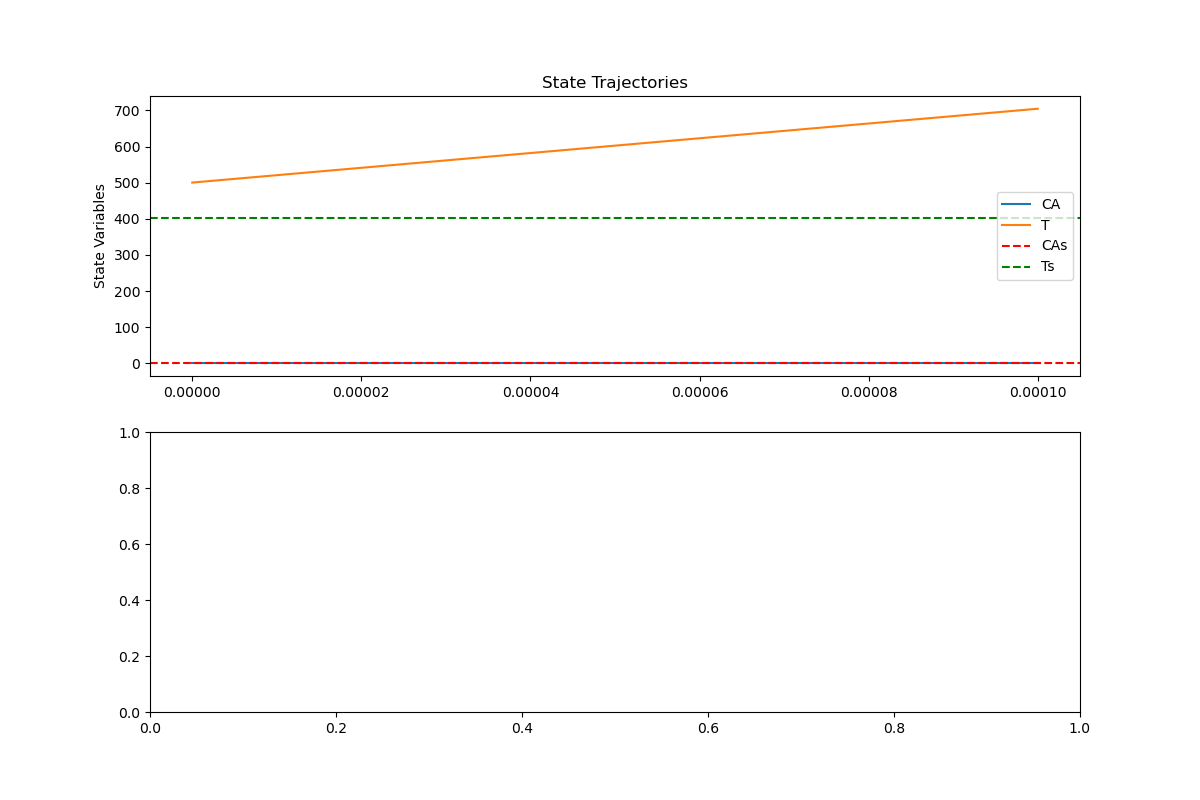

In [69]:
import matplotlib.pyplot as plt
import numpy as np
# Create time vector for plotting
t = np.linspace(0, tf, N+1)

# Plotting
plt.figure(figsize=(12, 8))

# Plot states
plt.subplot(2, 1, 1)
plt.plot(t, X_opt[0, :], label='CA')
plt.plot(t, X_opt[1, :], label='T')
plt.axhline(y=CAs, color='r', linestyle='--', label='CAs')
plt.axhline(y=Ts, color='g', linestyle='--', label='Ts')
plt.ylabel('State Variables')
plt.legend()
plt.title('State Trajectories')

# Plot controls
plt.subplot(2, 1, 2)
plt.plot(t[:-1], U_opt[0, :], label='CA0')
plt.plot(t[:-1], U_opt[1, :], label='Q')
plt.axhline(y=CA0s, color='r', linestyle='--', label='CA0s')
plt.axhline(y=0, color='g', linestyle='--', label='Qs')  # Assuming Qs is 0 for simplicity
plt.ylabel('Control Inputs')
plt.xlabel('Time')
plt.legend()
plt.title('Control Trajectories')

plt.tight_layout()
plt.show()

iteration 0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       72
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:       42
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       22
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+

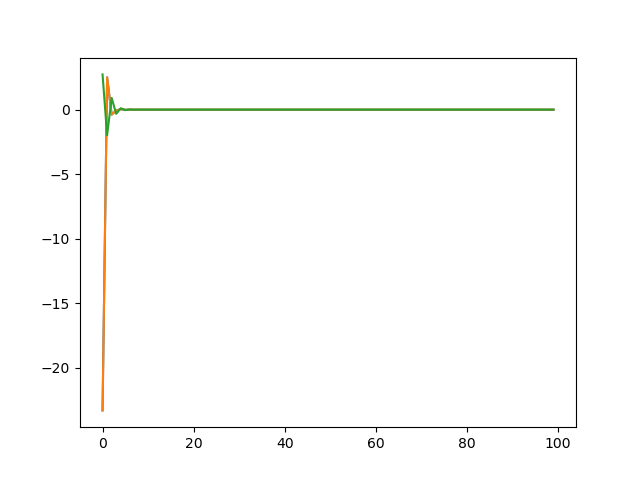

In [75]:
## This example was created using casadi 3.6.3 
## running on ubuntu 22.04 using python 3.10.12

import casadi as cs
import numpy as np
import matplotlib.pyplot as plt


def system_dynamics():
    x1 = cs.MX.sym("x1", 1,1)
    x2 = cs.MX.sym("x2", 1,1)
    x = cs.vertcat(x1,x2)

    u1 = cs.MX.sym("u1", 1,1)
    u2 = cs.MX.sym("u2", 1,1)
    u = cs.vertcat(u1,u2)

    x_next = cs.vertcat(-x1**3 - x2 + u1,
                        -2*x2 + u2)
    
    ode = cs.Function('ode',[x, u], [x_next], ['x','u'],['x_next'])
    return ode

def optimization_problem(N:int)->cs.Function:
    opti = cs.Opti("nlp")
    x = opti.variable(2,N+1)
    u = opti.variable(2,N)
    x_ref = opti.parameter(2,N+1)
    x0 = opti.parameter(2,1)
    opti.subject_to(x[:,0]==x0)
    ode = system_dynamics()
    for k in range(N):
        opti.subject_to(x[:,k+1] == ode(x[:,k], u[:,k]))
        opti.subject_to(opti.bounded(-100 ,u[:,k],100))
    
    cost = cs.sumsqr(x - x_ref) \
         + cs.sumsqr(u)
    
    opti.minimize(cost)
    solver = 'ipopt'
    p_opts = {'expand': True, 'verbose_init': False}
    s_opts = {'linear_solver': 'mumps','print_level': 0, 'warm_start_init_point': "yes",'error_on_fail': True}    
    opti.solver(solver, p_opts, s_opts)
    
    func = opti.to_function('controller', [x0, x_ref, u], [u[:,0]], ['x0','x_ref', 'u_init'], ['u'] )

    return func


N = 10
ode = system_dynamics()


controller = optimization_problem(N)

x0 = np.array([-3,2]).reshape(2,1)
x_ref = np.zeros((2,N+1))
u_ref = np.zeros((2,N))
x_log = np.zeros((2,10*N))
u_log = np.zeros((2,10*N))
for i in range(10*N):
    print("iteration", i)
    u = controller(x0, x_ref, u_ref) 
    u_log[:,i:i+1] = u 
    x_log[:,i:i+1] = x0
    x0 = ode(x0, u)

plt.figure("State")
plt.plot(x_log[0,:])
plt.plot(x_log[1,:])

plt.figure("input")
plt.plot(u_log[0,:])
plt.plot(u_log[1,:])

plt.show()

In [70]:
X_opt

array([[-9.99952534e-09, -9.99847621e-09],
       [ 5.00315798e+02,  7.04741036e+02]])

In [71]:
U_opt

array([8222.61156962,    0.        ])